# <span style="color:green"> Numerical Simulation Laboratory: Numerical Exercises 7 </span>

## <span style="color:steelblue"> Comment on the C++ code - Structure </span> 
The C++ code of the three programs is based on two versions of the class **Canonical** (canonical.h, canonical.cpp) and on the class **MolDyn** (moldyn.cpp, moldyn.h, Exercise07.4). The two versions of **Canonical** are just an adaptation to the single requests of the exercises of the same "base" class, which contains:
1. **Data**.
    - An array for the particle positions X (double**);
    - The number of particles, blocks, and the steps of each block;
    - The parameters of the system: temperature, density, cutoff radius, volume, and the range of motion of the Metropolis sampling.


2. **Methods**. Alongside the constructors, the set and get methods, we have the following methods:
    - $\mathrm{AutoEquilibrium}$ tries to equilibrate the system. It performs a series of short simulation cycles and stops if the value of $U$ is sufficiently stable (comparing its standard deviation with a threshold) or if a maximum number of iterations is reached;
    - $\mathrm{Calibration}$ helps the Metropolis algorithm to reach the $50\%$ of acceptance (fails only for the gas phase, whose best acceptance ratio is $\sim 60\%$).
    - $\mathrm{Move}$ alters the particle configurations using the Metropolis algorithm and computes the instantaneous values of $U$ and $P$.
    - $\mathrm{Simulate}$ performs the simulation cycles and outputs the desired measures (the instantaneous values of $U$ and $P$ or the sampling of the distribution $g(r)$.
    - Exercise 07.2 requires also the method $\mathrm{SampleG}$, which computes the distribution $g(r)$ for the actual configuration.
    
The class **MolDyn** instead is the evolution of the Molecular Dynamics class used in **Exercise04**, with the inclusion of the computation of $g(r)$ (via $\mathrm{SampleG}$, saved on file directly in the simulation method) and of the pressure $P$.

## <span style="color:steelblue"> Comment on the C++ code - Structure </span> 
The input file is **input.dat**. This is the only file that has to be modified in order to perform a new simulation.<br>
At the end of the simulation, the output data can be found in the folder **Outputdata**. However, by executing the scripts **solid.sh**, **liquid.sh** or **gas.sh**, the output files (referring to the three phases) can be copied to the corresponding folders **/solid**, **/liquid** and **/gas**, which are not affected by the C++ program (invoking **make clear** preserves these folders, since it acts only on **OutputData**, that contains the new and temporary output). 

# <span style="color:orangered"> Exercise07.1 </span>

We first define some useful functions: **ReadInst** reads the instantaneous values of $U$, $P$, **Autocorrelation** finds the autocorrelation between blocks of data (for example, the $i^{th}$ and $j^{th}$ blocks of length $L$ belonging to the same array), **BlockProg** computes the progressive average and standard deviation, **PlotAc** and **PlotSigma** automatize the representation for a set of BlockLengths = [...] of the autocorrelation and the progressive error.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import os.path

def ReadInst(filename):
    Ncycles, U, P = [], [], []
    with open(filename) as file:
        Ncycles = int(file.readline().split()[1])
        for line in file:
            line = line.split()
            U.append(float(line[0]))
            P.append(float(line[1]))
    return Ncycles, U, P

def Autocorrelation(Array, L, ArraySize):
    Ac = []
    T1 = 0
    for i in range(0, ArraySize, L):
        T2 = i
        A = U[T1:T1+L]
        B = U[T2:T2+L]
        CovAA, CovBB, CovAB = np.cov(A, A), np.cov(B, B), np.cov(A, B)
        Ac.append(math.sqrt(CovAB[0][1]**2/(CovAA[0][1]*CovAA[0][1])))
    return Ac


def BlockProg(data, Nsample, Nblocks):
    L = int(Nsample/Nblocks)
    block_average, total_sum, total_sum2 = 0, 0, 0
    prog_average, prog_sigma = [], []
    block_average = 0.0
    for k in range(L):
        block_average += data[k];
    
    block_average /= float(L)
    total_sum = block_average
    total_sum2 = block_average*block_average
    prog_average.append(block_average)
    prog_sigma.append(0)

    for n in range(1, Nblocks):
        block_average = 0.0
        for k in range(L):
            block_average += data[n*L + k]
        block_average /= float(L)
        total_sum += block_average
        total_sum2 += block_average*block_average
        prog_average.append(total_sum/float(n+1))
        prog_sigma.append( math.sqrt( (total_sum2/float(n+1)- prog_average[n]*prog_average[n])/float(n)))
    return prog_average, prog_sigma

def PlotAc(U, P, BlockLengths, Residue, Colors, Phase):
    N = len(BlockLengths)
    MaxNumberBlocks = min(int((len(U)-Residue[N-1])/BlockLengths[N-1]), 50)
    DataSize = [BlockLengths[i]*MaxNumberBlocks for i in range(N)]
    Ac_U, Ac_P = [], []
    for i in range(len(BlockLengths)):
        Ac_U.append(Autocorrelation(U, BlockLengths[i], DataSize[i]))
        Ac_P.append(Autocorrelation(P, BlockLengths[i], DataSize[i]))
        
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(r"Autocorrelation of U and P - "+Phase, y = 1, fontsize=16)
    fig.subplots_adjust(hspace=0.25, wspace=0.25)
    ax = ax.flatten()
    alpha=[0.6 for i in range(N-1)]
    alpha.append(1)
    for i in range(len(BlockLengths)):
        ax[0].plot(np.arange(0, len(Ac_U[i])), Ac_U[i], color=Colors[i], label=f"Block Length = {BlockLengths[i]}", 
                  alpha = alpha[i])
        ax[0].legend(prop={"size":12})
        ax[0].set_title("Internal energy", fontsize=13)
        ax[0].set_xlabel("Second block considered", fontsize=13)
        ax[0].set_ylabel("Autocorrelation", fontsize=13)
        ax[1].plot(np.arange(0, len(Ac_P[i])), Ac_P[i], color=Colors[i], label=f"Block Length = {BlockLengths[i]}", 
                   alpha=alpha[i])
        ax[1].legend(prop={"size":12})
        ax[1].set_title("Pressure", fontsize=13)
        ax[1].set_xlabel("Second block considered", fontsize=13)
        ax[1].set_ylabel("Autocorrelation", fontsize=13)
    plt.show()
    
def PlotSigma(U, P, BlockLengths, Colors, Phase):
    N = len(BlockLengths) # Number of block lengths to be represented
    Nblocks = int(len(U)/BlockLengths[N-1]) # Using the same number of blocks (otherwise the plot gets scaled)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(r"Statistical uncertainties - "+Phase, y = 1, fontsize=16)
    fig.subplots_adjust(hspace=0.25, wspace=0.25)
    ax = ax.flatten()
    alpha=[0.6 for i in range(N-1)]
    alpha.append(1)
    for i in range(N):
        SampleSize = Nblocks*BlockLengths[i]
        # Internal energy
        prog_U = BlockProg(U, SampleSize, Nblocks)
        ax[0].plot(np.arange(1, Nblocks+1), prog_U[1], #color=Colors[i], 
                   label=f"Block Length = {BlockLengths[i]}", color=Colors[i], alpha=alpha[i])
        ax[0].legend(prop={"size":12})
        ax[0].set_title("Internal energy", fontsize=13)
        ax[0].set_xlabel("Block", fontsize=13)
        ax[0].set_ylabel(r"$\sigma$", fontsize=13)
        # Pressure
        prog_P = BlockProg(P, SampleSize, Nblocks)
        ax[1].plot(np.arange(1, Nblocks+1), prog_P[1],
                   label=f"Block Length = {BlockLengths[i]}", color=Colors[i], alpha=alpha[i])
        ax[1].legend(prop={"size":12})
        ax[1].set_title("Pressure", fontsize=13)
        ax[1].set_xlabel("Block", fontsize=13)
        ax[1].set_ylabel(r"$\sigma$", fontsize=13)
    plt.show()

### <span style="color:green"> Solid </span>
We represent the behaviour of the autocorrelation and of the statistical uncertainties (of both $U$ and $P$), for each of the three phases. By modifying the lists *BlockLengths, Residue* and *Colors* we can see this behaviour for an arbitrary choice of block lengths (less than the total number of measures, by default 500000).

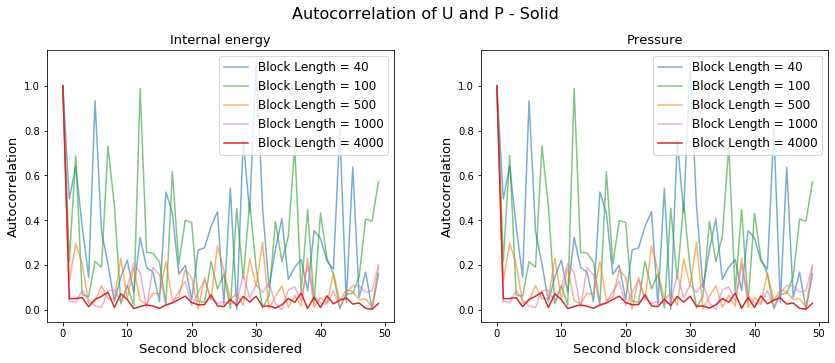

In [2]:
BlockLengths = [40, 100, 500, 1000, 4000] # Must be ordered. Also, < len(U)=len(P) (number of measures)
Residue = [0, 0, 0, 0, 0] # If BlockLength is not a divisor of len(U) = len(P), subtract the residue
Colors = ["tab:blue", "tab:green", "tab:orange", "tab:pink", "tab:red"]

Ncycles, U, P = ReadInst("Esercizio07.1/solid/inst_UP.out")
PlotAc(U, P, BlockLengths, Residue, Colors, "Solid")

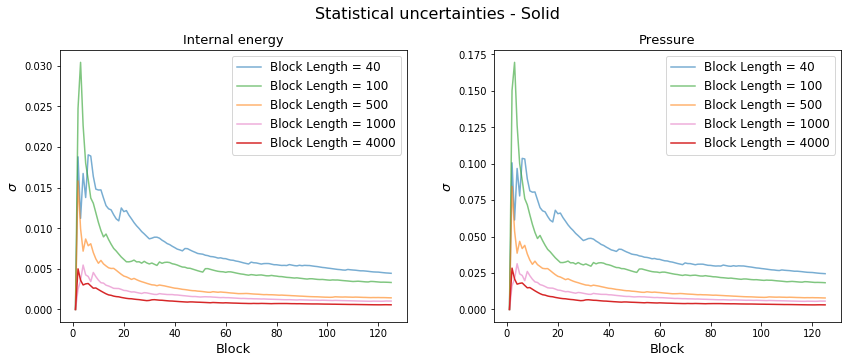

In [3]:
PlotSigma(U, P, BlockLengths, Colors, "Solid")

We see that once the block length surpasses *1000*, the autocorrelation between distant blocks quickly decreases and starts to oscillate (similar to a "noise") close to zero. In addition, the statistical uncertainties drop as the block length increases. Once the threshold of $\sim 1000$ elements is surpassed, the reduction in the value of $\sigma$ becomes smaller.

### <span style="color:green"> Liquid </span>

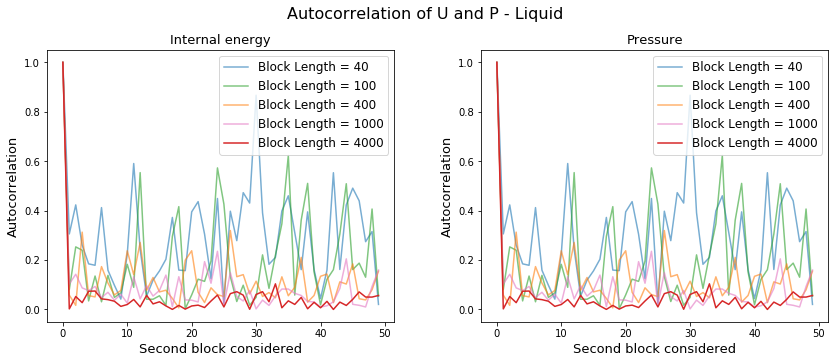

In [4]:
BlockLengths = [40, 100, 400, 1000, 4000] # Must be ordered
Residue = [0, 0, 0, 0, 0] # If BlockLength is not a divisor of len(U) = len(P), subtract the residue

Ncycles, U, P = ReadInst("Esercizio07.1/liquid/inst_UP.out")
PlotAc(U, P, BlockLengths, Residue, Colors, "Liquid")

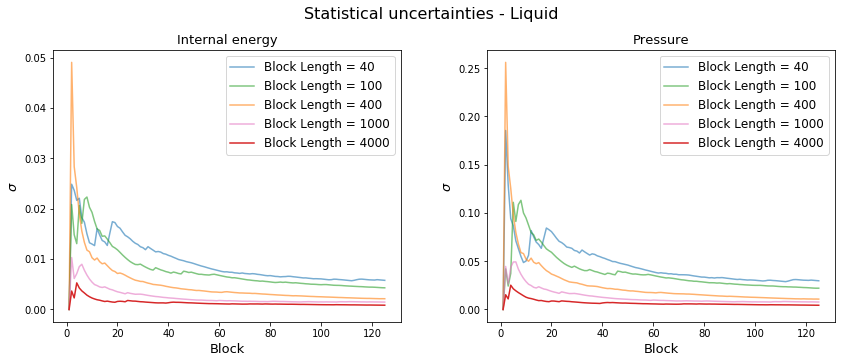

In [5]:
PlotSigma(U, P, BlockLengths, Colors, "Liquid")

The plots for the liquid phase lead to the same conclusion. However, we see that the correlation is lost more rapidly: this is even more evident for the gas phase.

### <span style="color:green"> Gas </span>

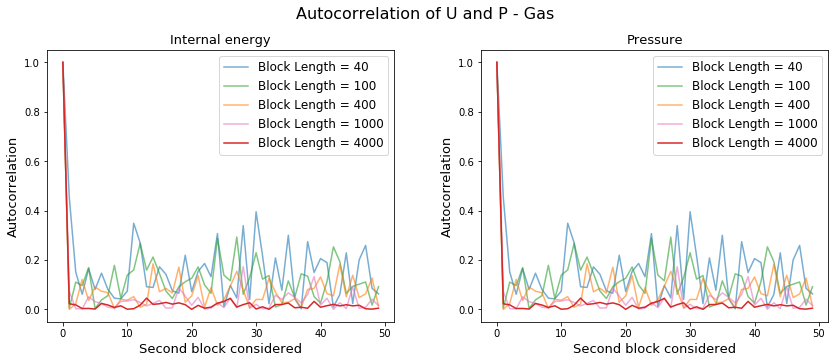

In [6]:
BlockLengths = [40, 100, 400, 1000, 4000] # Must be ordered
Residue = [0, 0, 0, 0, 0] # If BlockLength is not a divisor of len(U) = len(P), subtract the residue

Ncycles, U, P = ReadInst("Esercizio07.1/gas/inst_UP.out")
PlotAc(U, P, BlockLengths, Residue, Colors, "Gas")

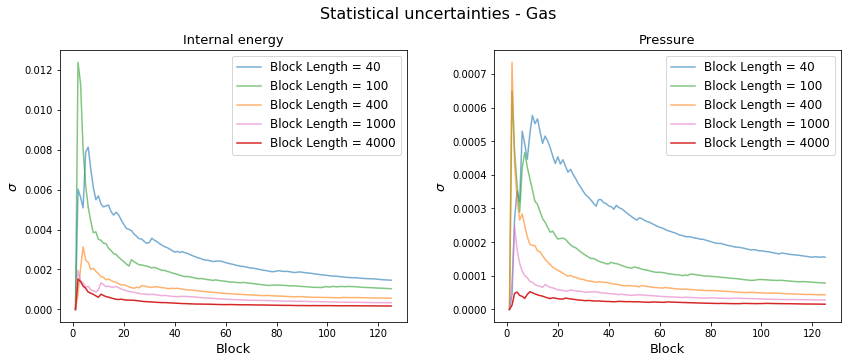

In [7]:
PlotSigma(U, P, BlockLengths, Colors, "Gas")

The autocorrelation function is significantly smaller for the gas phase than in the solid phase. This suggests that an **increase in the chaotic motion** of the particles leads to a **quicker loss of correlation** between adjacent configurations (blocks).

# <span style="color:orangered"> Exercise07.2 </span>

We first define the Read and Plot functions that will be used also in the Exercise07.4.

In [8]:
def ReadBlockG(filename):
    with open(filename) as file:
        Nbins = int(file.readline().split()[1])
        Nblocks = int(file.readline().split()[1])
        BoxEdge = float(file.readline().split()[1])
        Rcut = float(file.readline().split()[1])
        g = []
        for Bin in range(Nbins):
            g.append([])
        for Block in range(Nblocks):
            line = file.readline().split()
            for Bin in range(Nbins):
                g[Bin].append(float(line[Bin]))
    return Nbins, Nblocks, BoxEdge, Rcut, g

def ReadFinalG(filename):
    with open(filename) as file:
        Nbins = int(file.readline().split()[1])
        Nblocks = int(file.readline().split()[1])
        g_final_av, g_final_sigma = [], []
        for Bin in range(Nbins):
            line = file.readline().split()
            g_final_av.append(float(line[0]))
            g_final_sigma.append(float(line[1]))  
    return Nbins, Nblocks, g_final_av, g_final_sigma

def RadArray(Nbins, Rcut): # Generate the radius array (R value for each bin)
    Rad = []
    for Bin in range(Nbins):
        Rad.append(float(Bin+0.5)/float(Nbins)*Rcut)
    return Rad

def PlotFinalG(Exercise, a_0):
    Folders = ["/solid", "/liquid", "/gas"]
    Colors = ["tab:blue", "tab:green", "tab:red"]
    Titles = [r"Solid", r"Liquid", r"Gas"]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle(r"$g^{(2)}(r)$ distribution", y = 1, fontsize=17)
    fig.subplots_adjust(hspace=0.25, wspace=0.25)
    for i in range(3):
        Nbins, Nblocks, BoxEdge, Rcut, g_block = ReadBlockG(Exercise+Folders[i]+"/output.gofr.0")
        _, _, g_final_av, g_final_sigma = ReadFinalG(Exercise+Folders[i]+"/output.gave.0")
        Rad = RadArray(Nbins, Rcut)
        ax[i].errorbar(Rad, g_final_av, yerr=g_final_sigma, ecolor="black", color=Colors[i], label="Measure")
        ax[i].set_title(Titles[i], fontsize=14)
        ax[i].set_xlabel(r"Distance $r$", fontsize=14)
        ax[i].set_ylabel(r"$g^{(2)}(r)$", fontsize=14)
        ax[i].legend(prop={"size":12})
        if (i==0):
            ax[0].scatter([a_0, a_0*math.sqrt(2), a_0*math.sqrt(3)], [0, 0, 0], color="tab:orange") 

Then we plot the distribution $g(r)$ for each of the three phases considered.

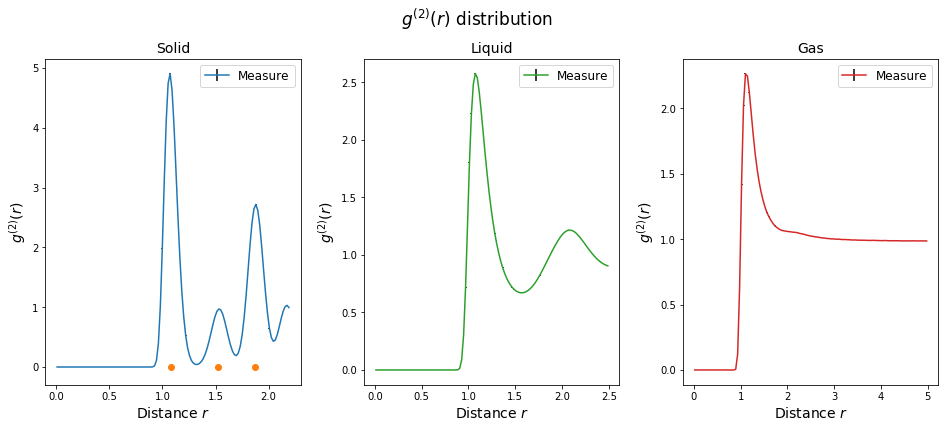

In [9]:
a_0 = 1.08 # Cell length - solid phase
PlotFinalG("Esercizio07.2", a_0)

The three distributions are close to zero for $r<r_{r}$, while it seems that for $r\longrightarrow\infty$ they approach 1. However, in the solid and liquid phase, $g(r)$ oscillates many times before getting closer to 1 (in particular, $g(r)$ is affected by wider oscillations in the solid phase). <br> Let us consider the first three peaks of the solid phase and the corresponding radii $r_1, r_2, r_3$. We decided to draw three dots at
$$ r_1 = a_0, \quad r_2 = \sqrt{2}a_0,\quad r_3 = \sqrt{3}a_0$$
with $a_0$ being a free parameter. Chosing $a_0 \sim 1.08$ leads to a correspondence between the position of the dots and the peaks: in fact, these three values of $r$ are the distances of the first three nearest-neighbours for a cubic cell, with cell length $a_0$. This shows that the equilibrium configuration for the solid phase gives rise to a cubic crystal structure.

# <span style="color:orangered"> Exercise07.4 </span>

In [10]:
# Lennard Jones units - SI units scaling factors
import math
from IPython.core.display import HTML
sigma = 3.4       # * 10^-10 m
epsilon = 1.657   # * 10^-21 J
m = 6.686         # * 10^-26 Kg
tau = 120         # K, Temperature scaling

def ReadParam(filename):
    with open("Esercizio07.4/"+filename) as file:
        # Simulation parameters
        file.readline().split()
        Input = [int(file.readline().split()[0]) for i in range(5)]
        Npart, Nsteps, Nblocks, Nbins, Nframes = Input
        if (Nframes!=0): Nframes = int(Nsteps/Nframes) # Conversion from a frequency to a total count
        # Equilibration parameters
        file.readline().split()
        Input = [int(file.readline().split()[0]) for i in range(2)]
        NcyclesEQ, NstepsEQ = Input
        # System parameters
        file.readline().split()
        Input = [float(file.readline().split()[0]) for i in range(4)]
        T, Rho, Rcut, dt = Input
    return Npart, Nsteps, Nblocks, Nbins, Nframes, NcyclesEQ, NstepsEQ, T, Rho, Rcut, dt

def ReadProgressiveUP(filename):
    Obs = [[[]for i in range(2)] for j in range(2)] # U, P [averages, sigma]
    with open("Esercizio07.4/"+filename) as file:
        for line in file:
            line = line.split()
            Obs[0][0].append(float(line[0]))
            Obs[0][1].append(float(line[1]))
            Obs[1][0].append(float(line[2]))
            Obs[1][1].append(float(line[3]))
    return Obs
      
def ConvertUnitsObs(Obs, epsilon, sigma):
    for i in range(2): # Energy
        for j in range(len(Obs[0][i])): 
            Obs[0][i][j] *= epsilon
            Obs[0][i][j] *= epsilon
    ConvP = epsilon/(sigma**3)*10**4 # in Pascal units
    for i in range(2): # Pressure
        for j in range(len(Obs[1][i])): 
            Obs[1][i][j] *= ConvP
            Obs[1][i][j] *= ConvP
    return Obs

def ConvertUnits(T, Rho, Rcut, epsilon, sigma, m, tau):
    Rho *= m/(sigma**3)*10**4 # Kg/m^3
    T *= tau
    Rcut *= sigma*10**(-10)
    return T, Rho, Rcut

def PlotTable(T, Rho, Rcut, dt):
    display(HTML("""<style>.output { display: flex; align-items: center; text-align: center; } </style> """))
    prec = '%1.3f'
    Text = [["Density", prec % Rho, r"$Kg\cdot m^{-3}$"], ["Temperature", prec % T, r"$K$"], 
             ["Cutoff radius", prec % (Rcut*(10**9)), r"$nm$"], ["Time step $\Delta t$", prec % dt, r"$s$"]]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,0.5))
    table = ax.table(cellText=[Text[i][1:3] for i in range(len(Text))], 
                     rowLabels=[Text[i][0] for i in range(len(Text))], 
                     colLabels=["Value", "Units"], loc="center", cellLoc="center", fontsize=15)
    table.set_fontsize(13)
    table.scale(1, 2.4)
    ax.axis("off")
    plt.show()
    
def PlotProgressive(Nsteps, Nblocks, Obs, T_target, Rho, Rcut, Labels, Ecolors, Ylabels):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    ax = ax.flatten()
    fig.subplots_adjust(hspace=0.20, wspace=0.27)
    fig.suptitle(f"Simulation - Progressive averages and errors  "+
                 f"[{Nblocks} blocks of length {Nsteps}]", y = 0.96, fontsize=16)
    for i in range(len(Obs)):
        ax[i].errorbar(np.arange(1, len(Obs[i][0])+1), Obs[i][0], yerr=Obs[i][1], color="black", 
                       ecolor=Ecolors[i], label=Labels[i])
        ax[i].set_xlabel("Blocks", fontsize=12)
        ax[i].set_ylabel(Ylabels[i], fontsize=12)
        ax[i].grid(True)
        ax[i].legend(prop={"size":16}) 
        
def PlotComparisonG(a_0):
    Folders = ["/solid", "/liquid", "/gas"]
    Titles = [r"Solid", r"Liquid", r"Gas"]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle(r"$g^{(2)}(r)$ distribution", y = 1, fontsize=17)
    fig.subplots_adjust(hspace=0.25, wspace=0.25)
    for i in range(3):
        Nbins, Nblocks, BoxEdge, Rcut, g_block = ReadBlockG("Esercizio07.2"+Folders[i]+"/output.gofr.0")
        _, _, g_final_av, g_final_sigma = ReadFinalG("Esercizio07.2"+Folders[i]+"/output.gave.0")
        Rad = RadArray(Nbins, Rcut)
        ax[i].errorbar(Rad, g_final_av, yerr=g_final_sigma, ecolor="black", color="black", label="Measure [07.2]")
        
        #ax[i].legend(prop={"size":12})
        
        Nbins, Nblocks, BoxEdge, Rcut, g_block = ReadBlockG("Esercizio07.4"+Folders[i]+"/output.gofr.0")
        _, _, g_final_av, g_final_sigma = ReadFinalG("Esercizio07.4"+Folders[i]+"/output.gave.0")
        #Rad = RadArray(Nbins, Rcut)
        ax[i].errorbar(Rad, g_final_av, yerr=g_final_sigma, ecolor="darkorange", color="darkorange", 
                       label="Measure [07.4]")
        ax[i].set_title(Titles[i], fontsize=14)
        ax[i].set_xlabel(r"Distance $r$", fontsize=14)
        ax[i].set_ylabel(r"$g^{(2)}(r)$", fontsize=14)
        ax[i].legend(prop={"size":12}, loc="upper right")
        if (i==0):
            ax[0].scatter([a_0, a_0*math.sqrt(2), a_0*math.sqrt(3)], [0, 0, 0], color="tab:orange")

### <span style="color:green"> Solid </span>

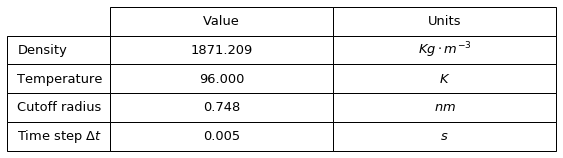

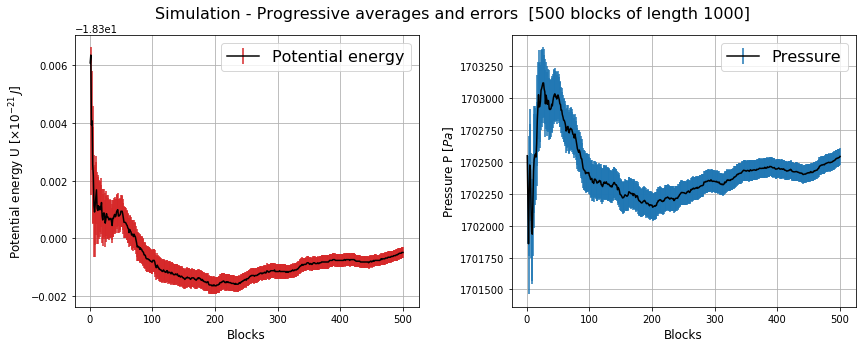

In [11]:
Labels = ["Potential energy", "Pressure"]
Ylabels = [r"Potential energy U $[\times 10^{-21}\thinspace J]$", r"Pressure P $[Pa]$"]
Ecolors = ["tab:red", "tab:blue"]

# Read parameters
Npart, Nsteps, Nblocks, Nbins, Nframes, _,_, T, Rho, Rcut, dt = ReadParam("solid/input.dat")
# Read the progressive values
Obs = ReadProgressiveUP("solid/output_prog_UP.dat")
# Convert U, P in SI units
T, Rho, Rcut = ConvertUnits(T, Rho, Rcut, epsilon, sigma, m, tau)
Obs = ConvertUnitsObs(Obs, epsilon, sigma)


PlotTable(T, Rho, Rcut, dt)
PlotProgressive(Nsteps, Nblocks, Obs, T, Rho, Rcut, Labels, Ecolors, Ylabels)

### <span style="color:green"> Liquid </span>

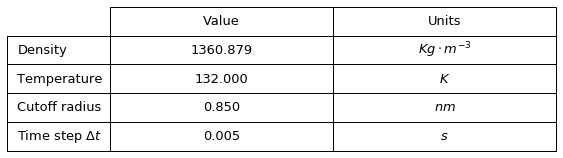

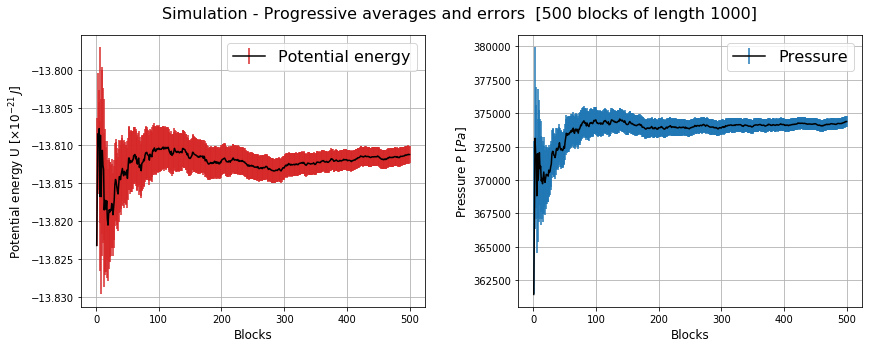

In [12]:
Labels = ["Potential energy", "Pressure"]
Ylabels = [r"Potential energy U $[\times 10^{-21}\thinspace J]$", r"Pressure P $[Pa]$"]
Ecolors = ["tab:red", "tab:blue"]

# Read parameters
Npart, Nsteps, Nblocks, Nbins, Nframes, _,_, T, Rho, Rcut, dt = ReadParam("liquid/input.dat")
# Read the progressive values
Obs = ReadProgressiveUP("liquid/output_prog_UP.dat")
# Convert U, P in SI units
T, Rho, Rcut = ConvertUnits(T, Rho, Rcut, epsilon, sigma, m, tau)
Obs = ConvertUnitsObs(Obs, epsilon, sigma)

display(HTML("""<style>.output { display: flex; align-items: center; text-align: center; } </style> """))
PlotTable(T, Rho, Rcut, dt)
PlotProgressive(Nsteps, Nblocks, Obs, T, Rho, Rcut, Labels, Ecolors, Ylabels)

### <span style="color:green"> Gas </span>

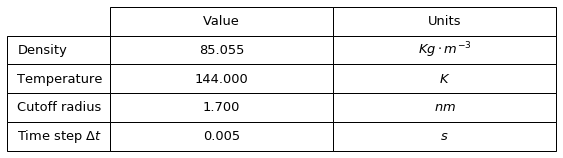

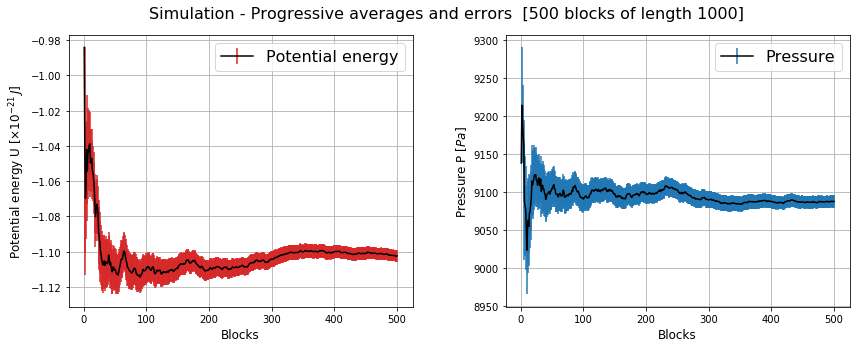

In [13]:
Labels = ["Potential energy", "Pressure"]
Ylabels = [r"Potential energy U $[\times 10^{-21}\thinspace J]$", r"Pressure P $[Pa]$"]
Ecolors = ["tab:red", "tab:blue"]

# Read parameters
Npart, Nsteps, Nblocks, Nbins, Nframes, _,_, T, Rho, Rcut, dt = ReadParam("gas/input.dat")
# Read the progressive values
Obs = ReadProgressiveUP("gas/output_prog_UP.dat")
# Convert U, P in SI units
T, Rho, Rcut = ConvertUnits(T, Rho, Rcut, epsilon, sigma, m, tau)
Obs = ConvertUnitsObs(Obs, epsilon, sigma)

display(HTML("""<style>.output { display: flex; align-items: center; text-align: center; } </style> """))
PlotTable(T, Rho, Rcut, dt)
PlotProgressive(Nsteps, Nblocks, Obs, T, Rho, Rcut, Labels, Ecolors, Ylabels)

### <span style="color:green"> $g(r)$ distribution </span>

We now represent the distribution $g(r)$ for the three phases, computed with the Molecular Dynamics program. The most striking feature is the resemblance of these plots with the ones showed in *Exercise07.2*: indeed, two different algorithms give the same results. We also showed the three dots in the solid phase plot with the *same value* of $a_0 = 1.08$, which proves that the two algorithms predict two close values of cubic cell length.

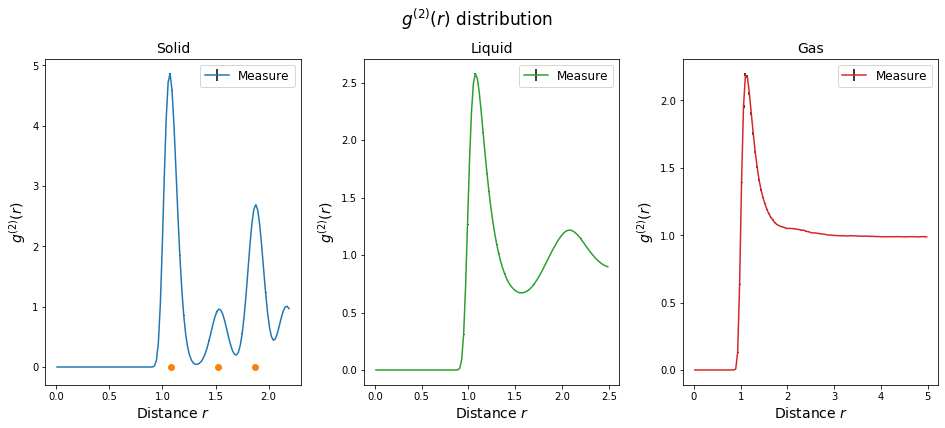

In [14]:
a_0 = 1.08 # Cell length - solid phase
PlotFinalG("Esercizio07.4", a_0)

We can also compare directly the results of Exercise07.2 and Exercise07.4 in the following graphs. They show that the two evaluations of $g(r)$ are almost identical for the solid and liquid phase, while for the gas phase they slightly disagree in a neighbourhood of the (only) peak.

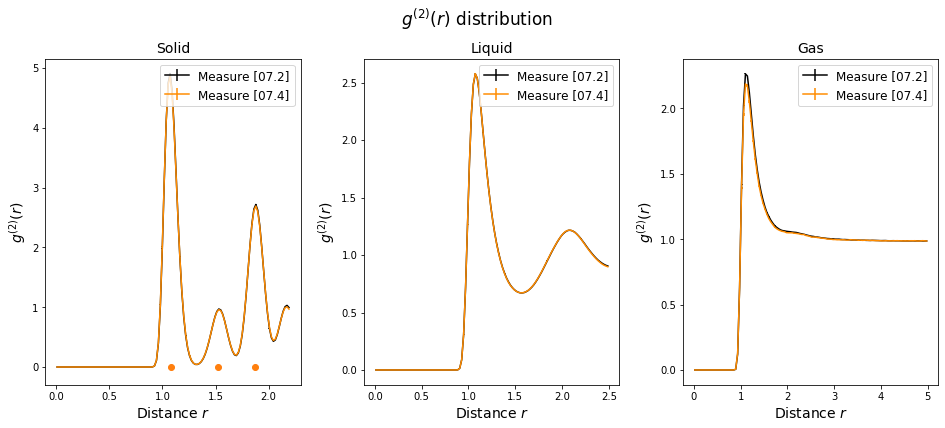

In [15]:
PlotComparisonG(a_0)